In [2]:
import sys
import os
sys.path.append("..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.gridspec as gridspec
import commembed.data as data
spark = data.spark_context()

matplotlib.rcParams['mathtext.fontset'] = 'custom'

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

%load_ext autoreload
%autoreload 2

Spark WebUI: http://ada.ais.sandbox:4042
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
embedding = load_embedding('reddit', 'master')
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)
plt.rcParams['font.family'] = 'Arial'

In [4]:
len(scores)

10006

# partisan validation

In [5]:
print("Loading validations...")
from commembed.dimens.validations import all_validations
validations = all_validations(embedding)
print("Done")

Loading validations...
Done


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


	Between universities and cities: r = 0.91, p=2.965331e-58, Cohen's d = 4.37
	n=150


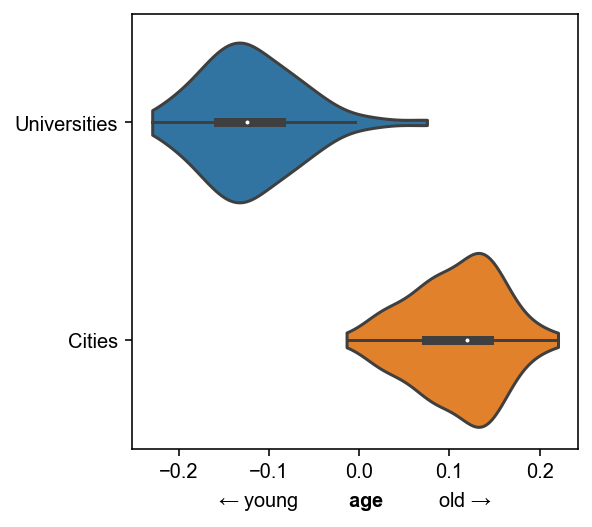

In [6]:
# University age validation
from scipy import stats

uni_to_city = pd.read_csv("../data/uni_to_city.csv")
uni_to_city = uni_to_city[uni_to_city["university"].isin(embedding.vectors.index)]
uni_to_city = uni_to_city[uni_to_city["city"].isin(embedding.vectors.index)]
uni_to_city = uni_to_city[uni_to_city["university"] != "WGU"] # Online university
unis_w_score = uni_to_city.join(scores["age"], on='university').join(scores["age"], on='city', lsuffix='_uni', rsuffix='_city')
unis_w_score['diff'] = unis_w_score['age_uni'] - unis_w_score['age_city']
unis_w_score = unis_w_score.sort_values('diff', ascending=True).reset_index()

    
def render_age_dists(fig, gs):
    ax = fig.add_subplot(gs)
    
    #bins = np.linspace(np.amin(unis_w_score["age_uni"]), np.amax(unis_w_score["age_city"]), 50)
    to_plot = unis_w_score[["age_uni", "age_city"]].melt()
    sns.violinplot(x="value", y="variable", orient="h", data=to_plot, cut=0)
    #sns.distplot(unis_w_score["age_uni"])
    #sns.distplot(unis_w_score["age_city"])
    ax.set_xlabel(axis_label("age"))

    c1 = unis_w_score["age_uni"]
    c0 = unis_w_score["age_city"]
    cohens_d = (np.mean(c0) - np.mean(c1)) / (np.sqrt((np.std(c0) ** 2 + np.std(c1) ** 2) / 2))
    corrcoef, p_value = stats.pearsonr(to_plot["variable"] == "age_city", to_plot["value"])

    print("\tBetween universities and cities: r = %.2f, p=%e, Cohen's d = %.2f" % (corrcoef, p_value, cohens_d))
    print("\tn=%d" % len(to_plot))
    
    ax.set_yticklabels(["Universities", "Cities"])
    ax.set_ylabel("")

    
fig = plt.figure(figsize=(4,4))
render_age_dists(fig, gridspec.GridSpec(1, 1, figure=fig)[0,0])
plt.show()

	Between left and right wing, r = 0.92; Cohen's d = 4.89
	p=2.934474e-21, n=50
Calcuating cohen's d, pooled standard dev is 0.080247, normal is 0.204676


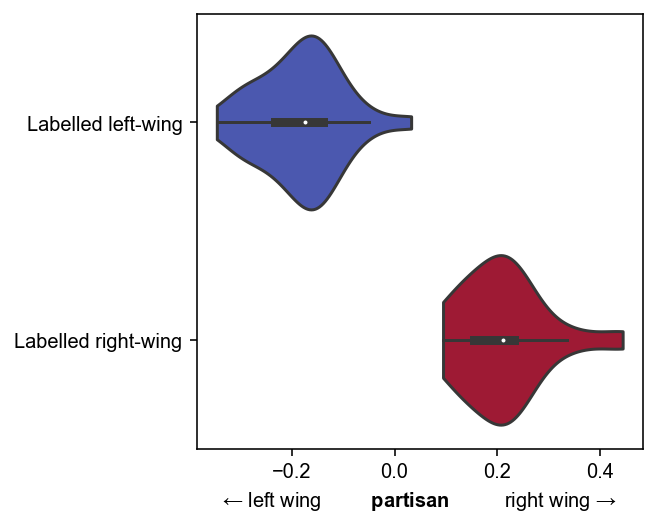

	Between labelled and unlabelled, r = 0.22; Cohen's d = 3.27
	p=9.442165e-112,n=10006
	Partisan-ness correct categorization 0.92


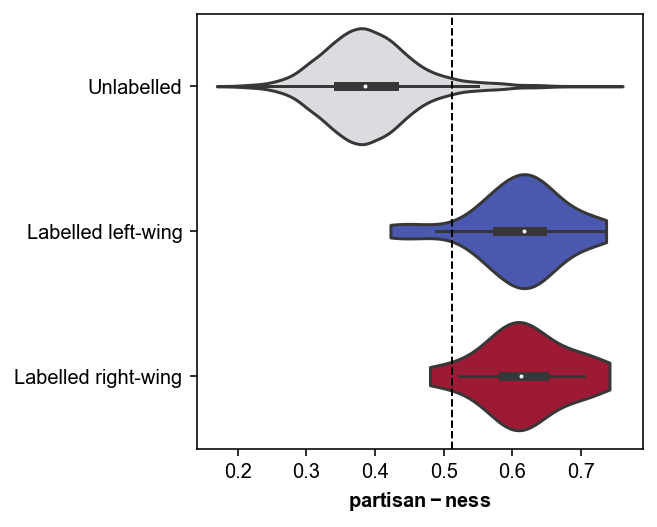

In [7]:
partisan_labels = pd.read_csv("../data/partisan_labelled.csv")

rep = plt.cm.coolwarm(500)
neutral = plt.cm.coolwarm(125)
dem = plt.cm.coolwarm(0)

ylabels = [None, "Unlabelled", "Labelled left-wing", "Labelled right-wing"]
    
def render_partisan_dists(fig, gs):
    ax = fig.add_subplot(gs)
    labelled = partisan_labels
    labelled = labelled[labelled["label"] != 1]

    
    sns.violinplot(x="partisan", y="label", data=labelled,  orient="h",
                    palette={2:dem, 3:rep}, cut=0)
    corr, p = stats.pearsonr(labelled["label"], labelled["partisan"])

    c1 = labelled[labelled["label"] == 2]["partisan"]
    c0 = labelled[labelled["label"] == 3]["partisan"]
    
    std_1 = np.std(list(c1)+list(c0))
    std_0 = (np.sqrt((np.std(c0) ** 2 + np.std(c1) ** 2) / 2))
    
    cohens_d = (np.mean(c0) - np.mean(c1)) / std_0
    #cohens_d = cohend(c0, c1)
    
    print("\tBetween left and right wing, r = %.2f; Cohen's d = %.2f" % (corr, cohens_d))
    print("\tp=%e, n=%d" % (p,len(labelled)))
    
    print("Calcuating cohen's d, pooled standard dev is %f, normal is %f" % ((np.sqrt((np.std(c0) ** 2 + np.std(c1) ** 2) / 2), \
                                                                              np.std(list(c1)+list(c0)))))
    
    #ax.annotate("$r = %.2f$\nCohen's $d = %.2f$" % (corr[0,1], cohens_d), (0, 0.4))
    ax.set_xlabel(axis_label("partisan"))
    ax.set_yticklabels(ylabels[2:])
    ax.set_ylabel("")
    
    return ax
    
def render_partisanness_dists(fig, gs):
    ax = fig.add_subplot(gs)
    labelled = partisan_labels
    
    labelled = scores[["partisan_neutral"]].join(labelled.set_index("community"))
    labelled["label"] = labelled["label"].fillna(1)
    
    sns.violinplot(x="partisan_neutral", y="label", data=labelled, orient="h",
                    palette={1: neutral, 2:dem, 3:rep},cut=0)
    corr, p = stats.pearsonr((labelled["label"] != 1).astype(int), labelled["partisan_neutral"])

    c1 = labelled[labelled["label"] == 1]["partisan_neutral"]
    c0 = labelled[labelled["label"] != 1]["partisan_neutral"]
    cohens_d = (np.mean(c0) - np.mean(c1)) / (np.sqrt((np.std(c0) ** 2 + np.std(c1) ** 2) / 2))
    #cohens_d = cohend(c0, c1)
    print("\tBetween labelled and unlabelled, r = %.2f; Cohen's d = %.2f" % (corr, cohens_d))
    print("\tp=%e,n=%d" % (p,len(labelled)))

    #ax.annotate("Cohen's $d = %.2f$" % (cohens_d), (0.2, 1.5))
    ax.set_xlabel(axis_label("partisan_neutral"))
    ax.set_yticklabels(ylabels[1:])
    ax.set_ylabel("")
    
    
    neutral_cutoff = neutral_cutoffs["partisan"]
    
    print("\tPartisan-ness correct categorization %.2f" % np.mean(labelled[labelled["label"] != 1]["partisan_neutral"] > neutral_cutoff))
    
    ax.axvline(neutral_cutoff, linewidth=1, linestyle='--', color='black')
    
    return ax

fig = plt.figure(figsize=(4,4))
render_partisan_dists(fig, gridspec.GridSpec(1, 1, figure=fig)[0,0])
plt.show()

fig = plt.figure(figsize=(4,4))
render_partisanness_dists(fig, gridspec.GridSpec(1, 1, figure=fig)[0,0])
plt.show()

In [8]:
from adjustText import adjust_text
from scipy import stats
    
def render_age_validation(fig, gs):
    ax = fig.add_subplot(gs)
    
    
    
    ax.scatter(unis_w_score['age_uni'], unis_w_score.index, label='University')
    ax.scatter(unis_w_score['age_city'], unis_w_score.index, label='City')
    ax.set_xlabel(axis_label("age"))
    
    fontsize = 8
    for i, entry in unis_w_score.iterrows():
        ax.annotate(entry['city'], (entry['age_city'], i),fontsize=fontsize)
        ax.annotate(entry['university'], (entry['age_uni'], i), ha='right',fontsize=fontsize,va='center')
    
    ax.set_xlim(-0.3, 0.3)
    ax.legend()
    
def render_validation(fig, gs, axis, validation_name, y_label):
    ax = fig.add_subplot(gs)
    
    df = validations[validation_name].join(scores, how='inner')
    
    x = df[axis]
    y= df["y"]
    
    
    corr_coef, p_value = stats.pearsonr(x, y)
    print("Validation %s: r=%.2f, p=%.4f, n=%d" % (validation_name, corr_coef, p_value, len(x)))
    ax.text(0.05, 0.95,'$r={:.2f}$\n$p={:.2e}$\n$n={:d}$'.format(corr_coef, p_value, len(x)),
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)
    
    sns.regplot(x, y, ax=ax)
    
    ax.set_xlabel(axis_label(axis))
    ax.set_ylabel(y_label)
    
    txts = []
    for comm, row in df.sample(20).iterrows():
        cx, cy = (row[axis], row['y'])
        txts.append(ax.text(cx, cy, comm, ha='center', va='center'))

    if validation_name == "us_census_occupations":
        ax.set_ylim(0, 1)
        
    adjust_text(txts, ax=ax, arrowprops=dict(arrowstyle="-"))
    
    return ax
    

	Between universities and cities: r = 0.91, p=2.965331e-58, Cohen's d = 4.37
	n=150
	Between left and right wing, r = 0.92; Cohen's d = 4.89
	p=2.934474e-21, n=50
Calcuating cohen's d, pooled standard dev is 0.080247, normal is 0.204676
	Between labelled and unlabelled, r = 0.22; Cohen's d = 3.27
	p=9.442165e-112,n=10006
	Partisan-ness correct categorization 0.92


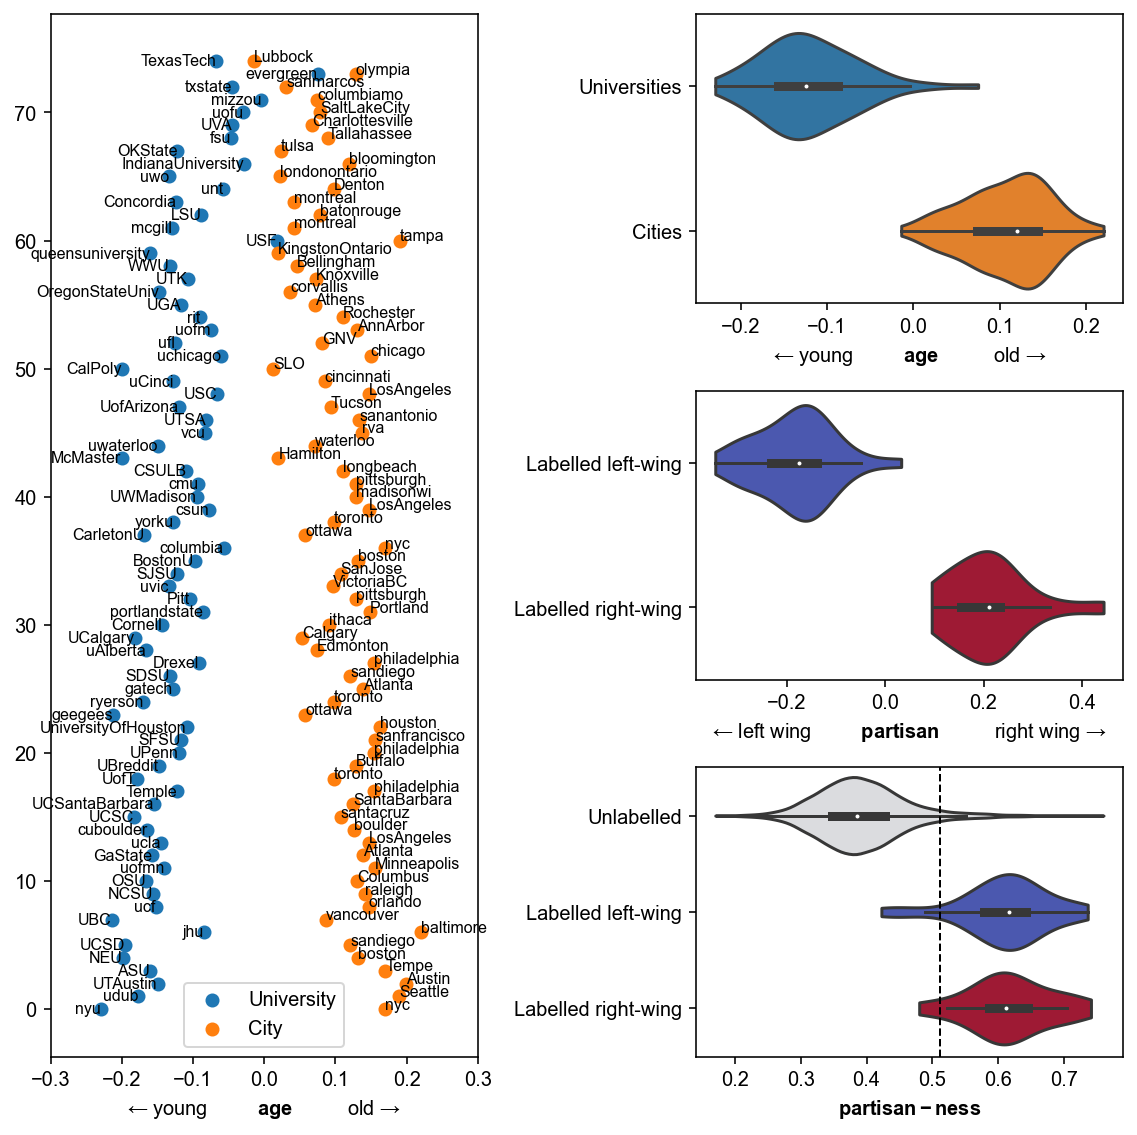

In [9]:

def validation_fig_1():
    fig = plt.figure(figsize=(8,8))

    gs0 = gridspec.GridSpec(6, 4, figure=fig)

    gs_age_1 = gs0[0:2, 2:]
    gs_age_2 = gs0[0:, 0:2]
    gs_partisan_1 = gs0[2:4, 2:]
    gs_partisan_2 = gs0[4:6, 2:]

    render_age_dists(fig, gs_age_1)
    render_age_validation(fig, gs_age_2)
    render_partisan_dists(fig, gs_partisan_1)
    render_partisanness_dists(fig, gs_partisan_2)

    
    plt.tight_layout()
    
    return fig, []
    
validation_fig_1()
plt.show()

Validation uscensus_income: r=0.42, p=0.0000, n=130


/u/walleris/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Validation us_election_2016: r=0.39, p=0.0000, n=112


/u/walleris/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Validation us_census_occupations: r=0.89, p=0.0000, n=23


/u/walleris/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


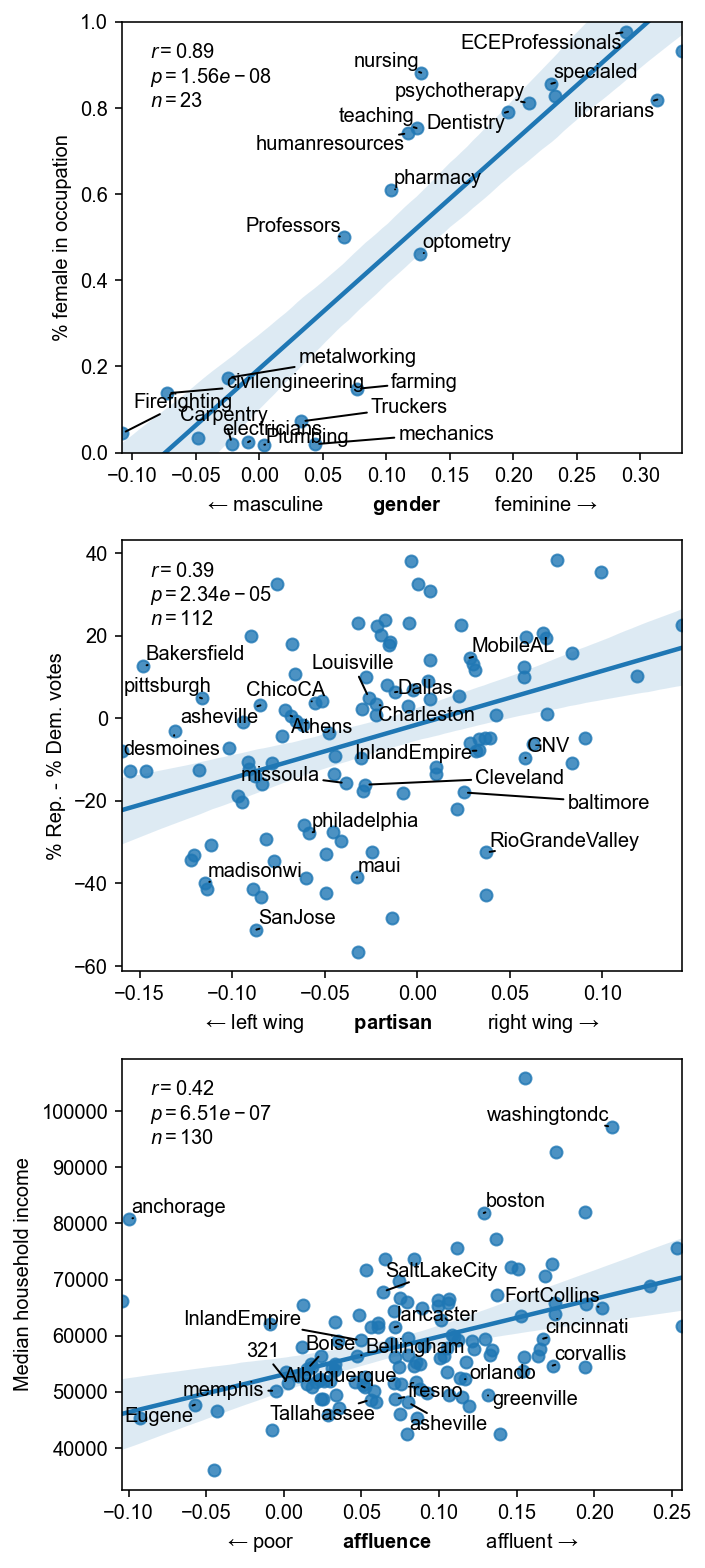

In [10]:

def validation_fig_2():
    fig = plt.figure(figsize=(5,11))

    gs0 = gridspec.GridSpec(6, 1, figure=fig)

    gs_gender = gs0[0:2]
    gs_partisan = gs0[2:4]
    gs_affluence = gs0[ 4:6]

    render_validation(fig, gs_affluence, "affluence", "uscensus_income", "Median household income")
    render_validation(fig, gs_partisan, "partisan", "us_election_2016", "% Rep. - % Dem. votes")
    render_validation(fig, gs_gender, "gender", "us_census_occupations", "% female in occupation")

    
    plt.tight_layout()
    
    return fig, []

validation_fig_2()
plt.show()

In [13]:
save_paper_figure(validation_fig_1(), "fig_A_validations_1", filetype='tiff')
save_paper_figure(validation_fig_2(), "fig_A_validations_2", filetype='tiff')

	Between universities and cities: r = 0.91, p=2.965331e-58, Cohen's d = 4.37
	n=150
	Between left and right wing, r = 0.92; Cohen's d = 4.89
	p=2.934474e-21, n=50
Calcuating cohen's d, pooled standard dev is 0.080247, normal is 0.204676
	Between labelled and unlabelled, r = 0.22; Cohen's d = 3.27
	p=9.442165e-112,n=10006
	Partisan-ness correct categorization 0.92
Aspect ratio: 1.0000
Saved fig_A_validations_1
Validation uscensus_income: r=0.42, p=0.0000, n=130


/u/walleris/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Validation us_election_2016: r=0.39, p=0.0000, n=112


/u/walleris/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Validation us_census_occupations: r=0.89, p=0.0000, n=23


/u/walleris/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Aspect ratio: 2.2767
Saved fig_A_validations_2
